In [1]:
pwd

'/home/sh/lab/GAN'

In [2]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset

In [3]:
# Custom dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False):
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a')
        self.path2b = join(path2img, 'b')
        self.img_filenames = glob.glob(self.path2a + '/*')
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index].split('/')[-1])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index].split('/')[-1])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames)

In [4]:
# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

# Sample Data

/home/sh/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


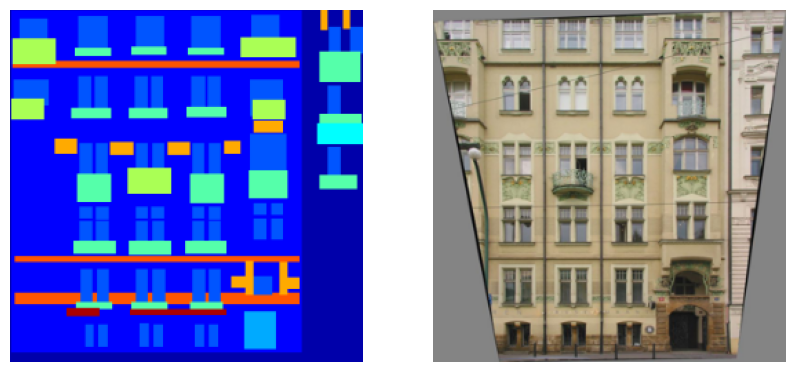

In [5]:
# 데이터셋 불러오기
path2img = '/home/sh/lab/GAN/data/facades/train'
train_ds = FacadeDataset(path2img, transform=transform)

# 샘플 이미지 확인하기
a,b = train_ds[0]
_=plt.figure(figsize=(10,10))
_=plt.subplot(1,2,1)
_=plt.imshow(to_pil_image(0.5*a+0.5))
_=plt.axis('off')
_=plt.subplot(1,2,2)
_=plt.imshow(to_pil_image(0.5*b+0.5))
_=plt.axis('off')

In [6]:
# 데이터 로더 생성하기
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# Define Model

## Generator

In [7]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x
    
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

In [8]:
# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

## Discriminator

In [9]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

In [10]:
# Discriminator은 patch gan을 사용합니다.
# Patch Gan: 이미지를 16x16의 패치로 분할하여 각 패치가 진짜인지 가짜인지 식별합니다.
# high-frequency에서 정확도가 향상됩니다.

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv2d(512,1,3,padding=1) # 16x16 패치 생성

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x

# Initialization Weights

In [11]:
# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

model_gen = GeneratorUNet().to(device)
model_dis = Discriminator().to(device)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [12]:
# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

# Train

In [13]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(num_epochs):
    for a, b in train_dl:
        ba_si = a.size(0)

        # real image
        real_a = a.to(device)
        real_b = b.to(device)

        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

        # generator
        model_gen.zero_grad()

        fake_b = model_gen(real_a) # 가짜 이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별

        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = gen_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis,real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

Epoch: 7, G_Loss: 32.744453, D_Loss: 0.040983, time: 0.48 min
Epoch: 15, G_Loss: 30.034824, D_Loss: 0.031013, time: 0.91 min
Epoch: 23, G_Loss: 29.422741, D_Loss: 0.040925, time: 1.34 min
Epoch: 30, G_Loss: 27.325905, D_Loss: 0.019178, time: 1.76 min
Epoch: 38, G_Loss: 24.655737, D_Loss: 0.011208, time: 2.19 min
Epoch: 46, G_Loss: 25.530554, D_Loss: 0.023039, time: 2.62 min
Epoch: 53, G_Loss: 23.986107, D_Loss: 0.008876, time: 3.05 min
Epoch: 61, G_Loss: 21.601303, D_Loss: 0.011302, time: 3.47 min
Epoch: 69, G_Loss: 21.352251, D_Loss: 0.211062, time: 3.90 min
Epoch: 76, G_Loss: 20.593727, D_Loss: 0.044107, time: 4.33 min
Epoch: 84, G_Loss: 20.975418, D_Loss: 0.016663, time: 4.76 min
Epoch: 92, G_Loss: 20.153154, D_Loss: 0.009877, time: 5.18 min
Epoch: 99, G_Loss: 20.301598, D_Loss: 0.708948, time: 5.61 min


# Visualize Result

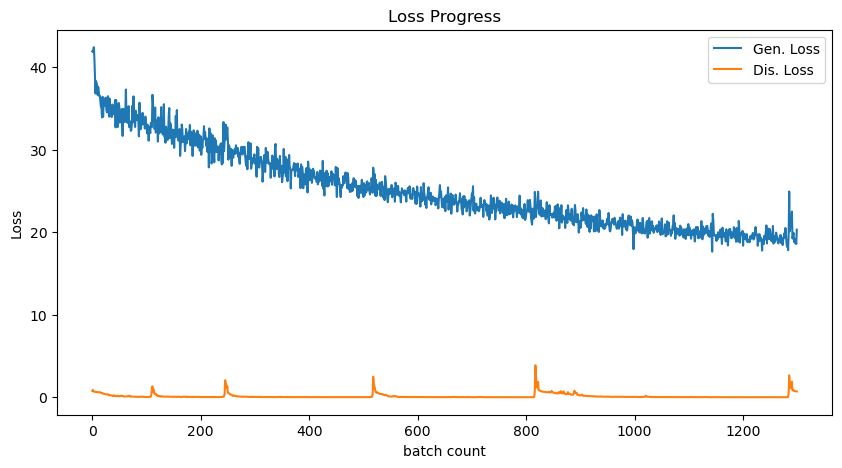

In [15]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# 가중치 저장
path2models = './pix2pix/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [17]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [18]:
# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_dl:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = b
        break

## Output(Fake)

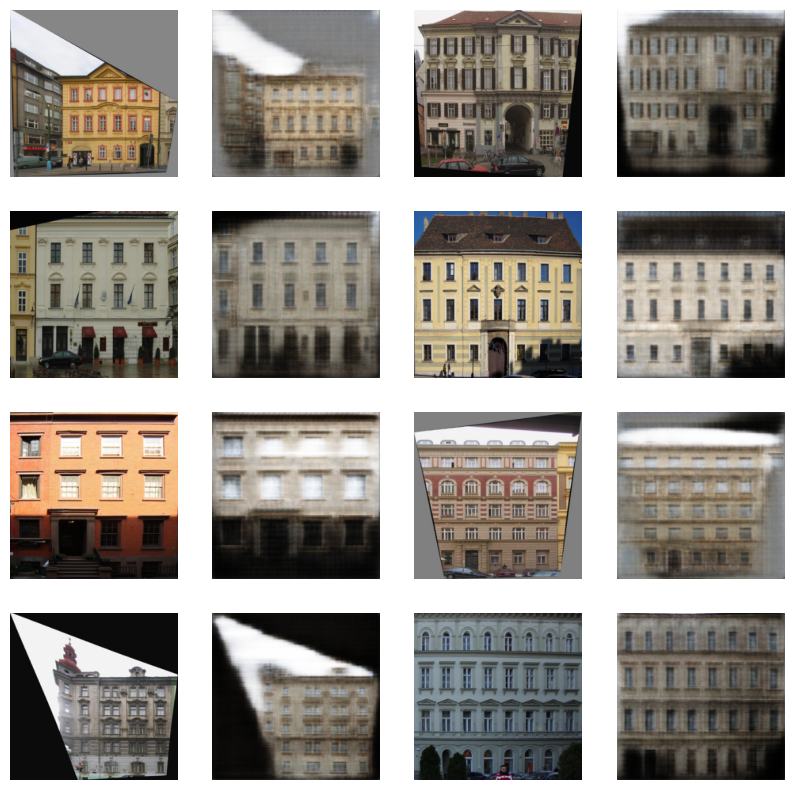

In [19]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')